In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold 
from sklearn import cluster 
from sklearn import preprocessing 

### Load the dataset

In [3]:
df = pd.read_csv("./prepared_mushrooms_sample.csv")

df.head(1)

,Unnamed: 0,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,...,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
0,0,1,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0


##### Dropping irrelevant col

In [4]:
df = df.drop('Unnamed: 0', axis=1)
df.head(1)

,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,...,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
0,1,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0


In [5]:
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (4000, 95)


## Rescale Data

#### Other than ring-number all data is either 0 or 1 (was orginally categorical), 
##### can convert ring-number into an interval between [0,1] using MinMaxScaler

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)


##### Using code from lab 3 - can visualise the cluster 

In [7]:
colors = np.array(['orange', 'blue', 'lime', 'yellow', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## K Means clustering 

#### K means clustering is an unsupervised machine learning algorithm, the goal of the algorithm is 
#### to find groups within the dataset, the algorithm works by assigning each data point to 
#### one of the k clusters 

##### Finding the optimal value for k using the Elbow technique 

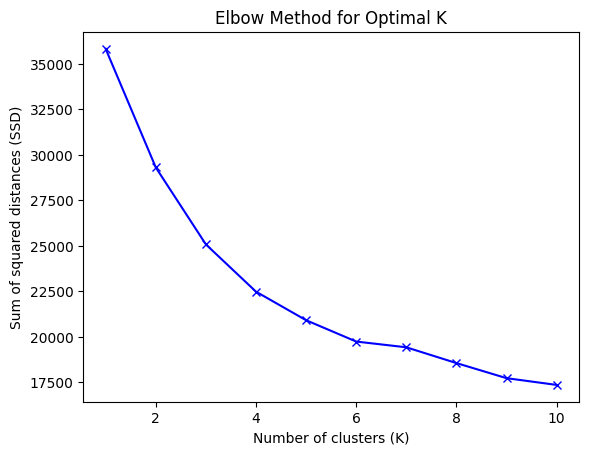

In [29]:
k_values = range(1, 11)

# Calculate SSD for each value of K
ssd = []
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k,n_init=10, random_state=0)
    kmeans.fit(data)
    ssd.append(kmeans.inertia_)

# Plot the SSD values for each K
plt.plot(k_values, ssd, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method for Optimal K')
plt.show()

##### the elbow method will run kmeans on the dataset for a range values, in this case 1 to 10
##### the plot is the mean distance, what we are lookinh for is the 'elbow point', where the
##### rate of decrease changes. In the plot above we see the curve drop significantly until we 
##### reach k=6, here the curver seems to level off 

### Using the silhouette technique to back up elbow technique 

In [33]:
from sklearn.metrics import silhouette_score

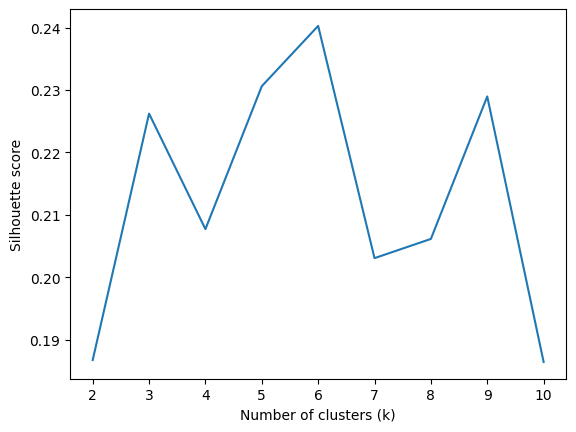

In [35]:
# Range of k values to test
k_values = range(2, 11)

# Initialize list to store silhouette scores
silhouette_scores = []

# Compute silhouette scores for each k
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, n_init=10,random_state=0)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, cluster_labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

##### the silhouette score / technique measures how similar a data point is within a cluster, compared
##### to other clusters, scikit learn provides a module that allows for the silhouette score to 
##### be calculated. we then plot a graph of these scores, the aim is to find the maximum silhoutte 
##### score. Looking at the graph is it clear that k=6 achived the max score 

### Both the elbow and silhouette have determined that the best value for k is 6

In [37]:
k = 6

In [38]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

## Applying multi-dimensional scaling (MDS) to project the data and
## K means clusters to a 2D space

In [39]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

In [40]:
XYcoordinates = manifold.MDS(n_components=2,normalized_stress=False).fit_transform(data_and_centers)

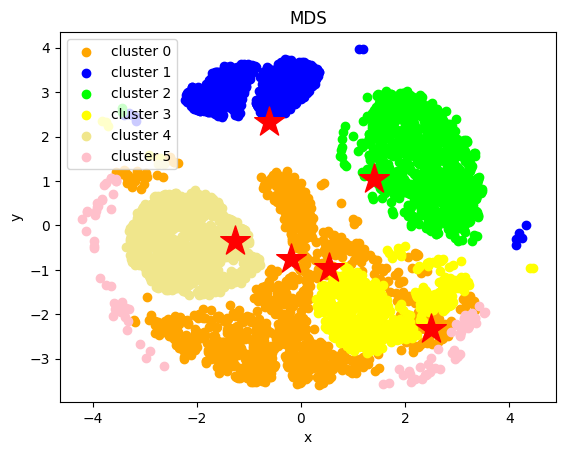

In [45]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

## Applying t-SNE to project the data and clusters to a 2D space

In [47]:
XYcoordinates = manifold.TSNE(n_components=2,).fit_transform(data_and_centers)

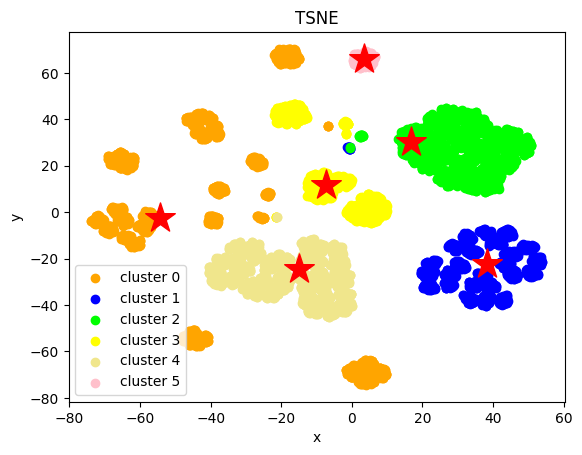

In [48]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### Adding the cluster labels to the original dataframe 

In [49]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

#### mean value for each attribute for each cluster

In [51]:
pd.set_option('display.max_columns', None)
df_cluster = df.groupby('cluster').mean()

In [58]:
df_cluster['class_poisonous'].head(6)

cluster
0    0.439921
1    1.000000
2    1.000000
3    0.009690
4    0.000000
5    0.000000
Name: class_poisonous, dtype: float64

##### Cluster 1 and 2 are poisonous mushrooms, for the edible mushrooms the clusters seem to be scatered together as there is no clear serpeation between clusters  3, 4 and 5. Cluster 0 has an average value of 0.43 meaning almost half of the data points in this cluster are edible and the other half are poisonous. This observation applied to both MDS and TSNE

### Decided to reduce the numbers to 3 of clusters to see if we could get more defined clusters

In [10]:
k = 3

In [8]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

### MDS

In [ ]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]
XYcoordinates = manifold.MDS(n_components=2,normalized_stress=False).fit_transform(data_and_centers)


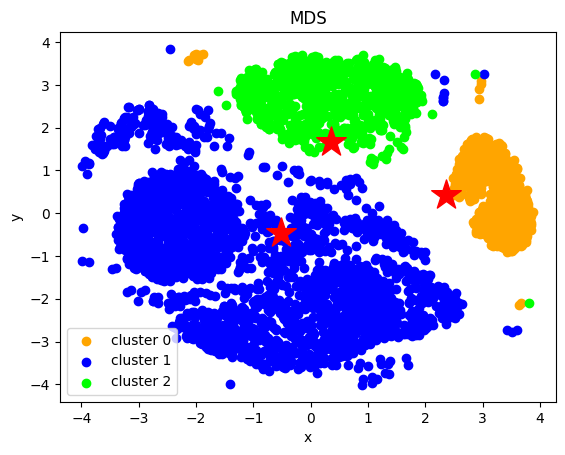

In [11]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

### TNSE

In [16]:
XYcoordinates = manifold.TSNE(n_components=2,).fit_transform(data_and_centers)

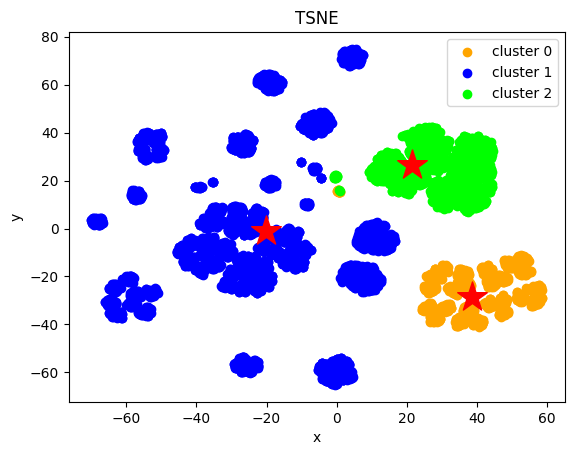

In [17]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### Using three clusters it seems we have combined 0, 3,4,5 from before as Cluster 1. 

In [13]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [15]:
pd.set_option('display.max_columns', None)
df_cluster = df.groupby('cluster').mean()
df_cluster.head()

,ring-number,bruises_true,cap-color_buff,cap-color_cinammon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,class_poisonous,gill-attachment_free,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,gill-size_narrow,gill-spacing_crowded,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,population_clustered,population_numerous,population_scattered,population_several,population_solitary,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,stalk-color-above-ring_buff,stalk-color-above-ring_cinammon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_buff,stalk-color-below-ring_cinammon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,stalk-root_club_1,stalk-root_equal_1,stalk-root_nan_1,stalk-root_rooted_1,stalk-shape_tapering,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,veil-color_orange,veil-color_white,veil-color_yellow
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.978884,0.000000,0.000000,0.003017,0.506787,0.000000,0.000000,0.000000,0.007541,0.000000,0.472097,0.000000,0.496229,0.499246,0.004525,0.00000,0.000000,0.521870,0.000000,1.000000,0.990950,0.000000,0.000000,0.310709,0.334842,0.000000,0.000000,0.333333,0.00000,0.000000,0.010558,0.010558,0.000000,0.000000,0.000000,0.000000,0.355958,0.000000,0.000000,0.340875,0.000000,0.00000,0.000000,0.978884,0.021116,0.000000,0.000000,0.00000,0.021116,0.00000,0.000000,0.487179,0.491704,0.000000,0.978884,0.021116,0.000000,0.000000,0.000000,0.978884,0.000000,0.00000,0.000000,0.021116,0.000000,0.330317,0.021116,0.000000,0.000000,0.307692,0.000000,0.000000,0.000000,0.312217,0.021116,0.00000,0.000000,0.333333,0.000000,0.000000,0.000000,0.021116,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.021116,0.978884,0.000000,0.000000,1.000000,0.000000
1,1.120098,0.680556,0.035948,0.006127,0.237337,0.004085,0.033905,0.002859,0.124592,0.204657,0.071895,0.000408,0.467320,0.391748,0.045752,0.00817,0.000817,0.335784,0.334967,0.183007,0.962827,0.198121,0.000000,0.066176,0.064542,0.006536,0.013072,0.203840,0.10049,0.022059,0.234069,0.013072,0.158905,0.251634,0.050654,0.060458,0.024918,0.080474,0.040033,0.407680,0.077614,0.04085,0.000000,0.062500,0.000000,0.684232,0.058007,0.00000,0.061275,0.07884,0.246324,0.334150,0.209559,0.008987,0.000000,0.000000,0.794935,0.379902,0.008987,0.071487,0.017974,0.00817,0.009804,0.115605,0.011029,0.000000,0.000000,0.102533,0.037173,0.121732,0.019199,0.715278,0.002042,0.000000,0.000000,0.10866,0.037173,0.116013,0.021242,0.703023,0.002042,0.102124,0.222631,0.140114,0.037173,0.563725,0.004085,0.028186,0.861111,0.041258,0.026552,0.818219,0.019199,0.960784,0.002042
2,0.997750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.469066,0.000000,0.007874,0.000000,0.320585,0.340832,0.332958,0.00000,0.000000,0.508436,0.480315,1.000000,0.997750,0.000000,0.978628,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.02024

##### Cluster 0 and 2 have a mean class_poisonous value of 1, meaning both of these clusters belong to the poisonous class, Cluster 1 has a mean clss_poisonous of 0.18 meaning a large majourity of this cluster belong to the edible class 

### I will begin by looking at the two poisnous clusters 0 and 2, to better understandw what defines a poisonous mushroom
#####  Looking at Cluster 0, we see an average number of rings of ~1, no bruises, an average of 0.50 for cap colour gray, 0.47 for cap colour of yellow, the cap shape is split between convex and flat, an average of .52 for cap surface scaly, due to the average being 0 for all other surface option we can assume the other .48 is for a fibrious surface. The average for a free gill attachment is high at .99. For gill colour it is split ~0.33 between chocolate, gray and pink. The habitat is divided between paths, woods and grasses. With an almound oder. The population type is divided between serveral and solitary. A large ring type is the most popular with an average of 0.97. The most popular spore print colour is chocolate at 0.97. The stalk colour above and below the ring is divided between brown,buff and pink. The stalk root type is bulbous. The stalk surface above and below is silky. Finally the veil colour is white 
##### Some differences with Cluster 1 are: cap colour is divided between brown and red, the shape is divided between  convex, flat and knobbed. The cap surface is divided between scaly and smooth. The gill colour is buff. The gill spacing is narrow. The habitat is divided between leaves, paths and woods. The odor is divided between almond, fishy and foul. The ring type is cobwebby. The spore print colour is white. 

### This clustering has shown that it is possible to seperate the two classes poisnous and edible based on the information given 
